## prior count statistics
- Yosuke Tanigawa (6/27/2017)

## Objective
- This notebook summarizes the basic statistics of blocks

In [1]:
%matplotlib inline

from __future__ import print_function

import sys
import logging
from logging.config import dictConfig
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
# import multiprocessing
# import bisect

# from numba import jit

# import pgenlib as pg

logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [2]:
logger_nb = logging.getLogger('notebook')
logger_nb.info('hello')

2017-06-27 15:09:35,768 notebook     INFO     hello


In [3]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'
prior_dir='{}/prior_count'.format(data_dir)
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
block_bed_f = '{}/{}.bed'.format(data_dir, block_log[:-4])

In [4]:
block_bed = pd.read_csv(block_bed_f, sep='\t', names=['chrom', 'chromStart', 'chromEnd', 'name'])
block_bed['bim_interval'] = block_bed.name.map(lambda x: [int(pos) for pos in x.split(':')])
block_bed['bimStart'] = block_bed.bim_interval.map(lambda x: x[0])
block_bed['bimEnd'] = block_bed.bim_interval.map(lambda x: x[1])
block_bed.head()

,chrom,chromStart,chromEnd,name,bim_interval,bimStart,bimEnd
0,chr20,61097,94951,0:78,"[0, 78]",0,78
1,chr20,94951,266791,78:915,"[78, 915]",78,915
2,chr20,266791,288775,915:991,"[915, 991]",915,991
3,chr20,288775,344630,991:1218,"[991, 1218]",991,1218
4,chr20,344630,346675,1218:1224,"[1218, 1224]",1218,1224


In [5]:
def get_stats_from_np(prior_dir, block_id):
    c = np.load('{}/{}.npz'.format(prior_dir, block_id))
    n_unique_haplotypes, _ = c['keys'].shape
    n_haplotypes_without_missing_data = np.sum(c['vals'])
    del c
    return n_unique_haplotypes,  n_haplotypes_without_missing_data

In [6]:
stats_from_npz = np.array([get_stats_from_np(prior_dir, block_id) 
                           for block_id in range(len(block_bed))])

In [7]:
block_bed['nt_size'] = block_bed.chromEnd - block_bed.chromStart
block_bed['n_SNPs'] = block_bed.bimEnd - block_bed.bimStart
block_bed['n_uniq_haps'] = stats_from_npz[:, 0]
block_bed['n_haps'] = stats_from_npz[:, 1]

In [8]:
block_bed_cols = [
    'chrom', 'chromStart', 'chromEnd', 'bimStart', 'bimEnd', 'nt_size', 'n_SNPs', 'n_haps', 'n_uniq_haps'
]

In [9]:
block_bed[block_bed_cols].head()

,chrom,chromStart,chromEnd,bimStart,bimEnd,nt_size,n_SNPs,n_haps,n_uniq_haps
0,chr20,61097,94951,0,78,33854,78,119900,4833
1,chr20,94951,266791,78,915,171840,837,24264,16646
2,chr20,266791,288775,915,991,21984,76,120130,6487
3,chr20,288775,344630,991,1218,55855,227,70042,16571
4,chr20,344630,346675,1218,1224,2045,6,202090,26


## save to a tsv file

In [10]:
block_tsv_f = '{}.tsv'.format(block_bed_f[:-4])
block_tsv_f

'/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.tsv'

In [11]:
block_bed[block_bed_cols].to_csv(block_tsv_f, index=False, sep='\t')

In [12]:
!head $block_tsv_f

chrom	chromStart	chromEnd	bimStart	bimEnd	nt_size	n_SNPs	n_haps	n_uniq_haps
chr20	61097	94951	0	78	33854	78	119900	4833
chr20	94951	266791	78	915	171840	837	24264	16646
chr20	266791	288775	915	991	21984	76	120130	6487
chr20	288775	344630	991	1218	55855	227	70042	16571
chr20	344630	346675	1218	1224	2045	6	202090	26
chr20	346675	368904	1224	1355	22229	131	87266	11161
chr20	368904	381669	1355	1405	12765	50	167090	2490
chr20	381669	536535	1405	1838	154866	433	44650	21721
chr20	536535	546545	1838	1887	10010	49	147164	1754


## plot 

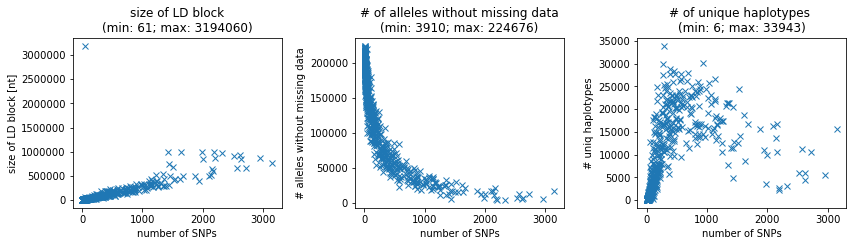

In [13]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].plot(block_bed.n_SNPs, block_bed.nt_size, 'x')
axs[1].plot(block_bed.n_SNPs, block_bed.n_haps, 'x')
axs[2].plot(block_bed.n_SNPs, block_bed.n_uniq_haps, 'x')
axs[0].set_ylabel('size of LD block [nt]')
axs[1].set_ylabel('# alleles without missing data')
axs[2].set_ylabel('# uniq haplotypes')
axs[0].set_title('size of LD block\n(min: {}; max: {})'.format(
    np.min(block_bed.nt_size), np.max(block_bed.nt_size)))
axs[1].set_title('# of alleles without missing data\n(min: {}; max: {})'.format(
    np.min(block_bed.n_haps), np.max(block_bed.n_haps)))
axs[2].set_title('# of unique haplotypes \n(min: {}; max: {})'.format(
    np.min(block_bed.n_uniq_haps), np.max(block_bed.n_uniq_haps)))
for ax in axs:
    ax.set_xlabel('number of SNPs')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])


In [14]:
fig.savefig('prior_count_stats.png')